#### Imports etc

In [1]:
nb_samples = 64
# list_features = ["longitude", "latitude", "groundspeed"] #, "track"] #, "altitude"]
# list_features = ["longitude", "latitude", "track"] #, "track"] #, "altitude"]
list_features = ["longitude", "latitude"]  # , "track"] #, "altitude"]
input_dim = len(list_features)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from traffic.core import Flight, Traffic

from trajectory_clustering.feature_preparation import fit_scaler, prepare_features, traffic_from_features

import wandb
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm.autonotebook import tqdm


np.random.seed(0)

torch.manual_seed(0)

t = Traffic.from_file("./data/resampled_t_near_ap.parquet")


/var/folders/6r/vdmz5zjj6_d8769grj_ht__80000gn/T/ipykernel_3489/2398213321.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Get the features

In [4]:
t.data["runway_name"].value_counts()

runway_name
28    167488
32     70400
16     32960
10      7168
34      5632
14        64
Name: count, dtype: int64

In [5]:
t_f = t.query("runway_name == '28'")
t_f

,count
flight_id,
AAL93_7720,64
SWR25P_4024,64
SWR252H_6245,64
SWR252H_6246,64
SWR2530_3232,64
SWR253J_1323,64
SWR253J_1371,64
SWR253J_1539,64
SWR253J_1743,64


In [6]:
scaler = fit_scaler(t_f.data[list_features].to_numpy())
scaler.data_range_, scaler.data_min_, scaler.data_max_

(array([0.025886, 0.026745]),
 array([ 8.544617, 47.440933]),
 array([ 8.570503, 47.467678]))

In [7]:
X, flight_order = prepare_features(t_f, list_features, scaler)
X

array([[-0.1233099 ,  0.59521407, -0.13659893, ...,  0.17674331,
         0.866337  ,  0.18003365],
       [-0.1684308 ,  0.6174986 , -0.17569342, ...,  0.2714152 ,
         0.7207757 ,  0.2714152 ],
       [-0.13791238,  0.6106188 , -0.1457931 , ...,  0.17584595,
         0.87035465,  0.18003365],
       ...,
       [-0.04921579,  0.00512245, -0.04643437, ...,  0.17741634,
         0.9139303 ,  0.1783137 ],
       [-0.09549563, -0.00213124, -0.09147802, ...,  0.17569639,
         0.9030364 ,  0.1783137 ],
       [ 0.05833269,  0.05522528,  0.07185351, ...,  0.17928585,
         0.9629143 ,  0.18018322]], dtype=float32)

#### test feature prep

In [35]:
t_f_test = traffic_from_features(
    X,
    t_f,
    flight_order,
    list_features,
    scaler
)


/var/folders/6r/vdmz5zjj6_d8769grj_ht__80000gn/T/ipykernel_6119/1258760137.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


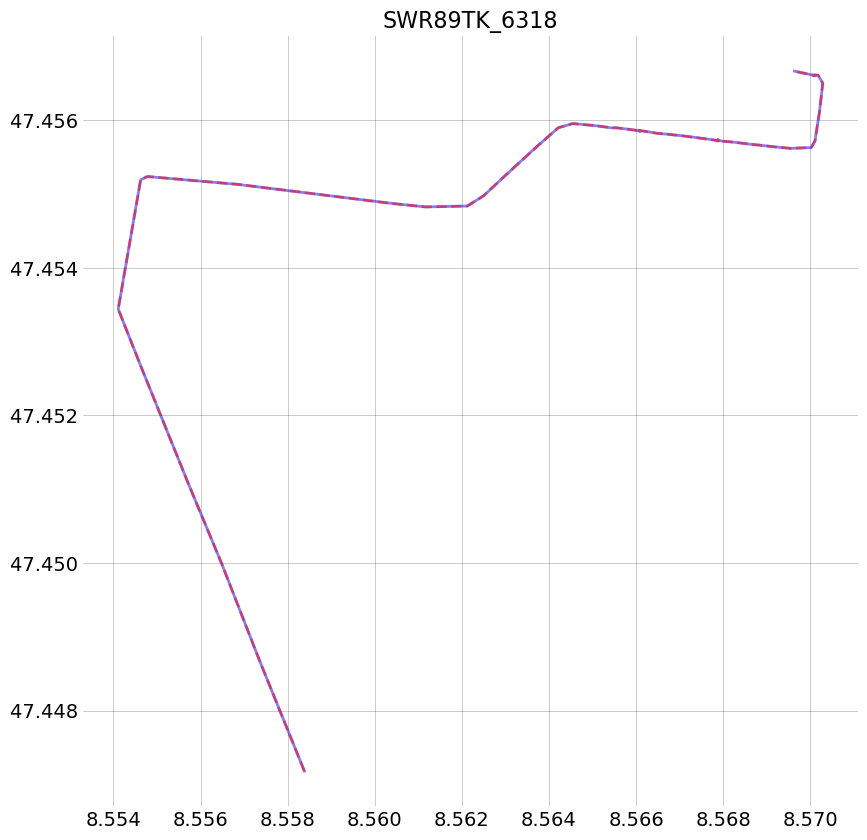

In [45]:
with plt.style.context("traffic"):
    flight_id = np.random.choice(t_f.flight_ids)

    fig, ax = plt.subplots(figsize=(10, 10))

    t_f[flight_id].plot(ax, label=flight_id, linewidth=2, c="blue", alpha=0.5)
    ax.set_title(flight_id)

    t_f_test[flight_id].plot(ax, label=flight_id, linestyle="--", linewidth=2, c="red", alpha=0.5)

    # ax.legend()
    fig.show()


#### VAE

In [ ]:
class VariationalAutoencoderGPT(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int],
        latent_dim: int,
        dropout: float = 0.0,
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim, hidden_dims, latent_dim, dropout, activation)
        self.decoder = Decoder(input_dim, hidden_dims[::-1], latent_dim, dropout, activation)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    def reparameterize(self, mu: Tensor, log_var: Tensor) -> Tensor:
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    

class Encoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int],
        latent_dim: int,
        dropout: float = 0.0,
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        modules = []
        for hidden_dim in hidden_dims:
            modules.append(nn.Linear(input_dim, hidden_dim))
            modules.append(activation)
            modules.append(nn.Dropout(dropout))
            input_dim = hidden_dim
        self.encoder = nn.Sequential(*modules)
        self.mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.log_var = nn.Linear(hidden_dims[-1], latent_dim)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var
    

class Decoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int],
        latent_dim: int,
        dropout: float = 0.0,
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        modules = []
        for hidden_dim in hidden_dims:
            modules.append(nn.Linear(latent_dim, hidden_dim))
            modules.append(activation)
            modules.append(nn.Dropout(dropout))
            latent_dim = hidden_dim
        self.decoder = nn.Sequential(*modules)
        self.output = nn.Linear(hidden_dims[-1], input_dim)

    def forward(self, x: Tensor) -> Tensor:
        x = self.decoder(x)
        x = self.output(x)
        return x


In [10]:
class VariationalEncoder(nn.Module):
    def __init__(self, activation_layer: nn.Module = nn.ReLU(), input_dim=2 * 64, latent_dim=2):
        super(VariationalEncoder, self).__init__()

        self.activation_layer = activation_layer
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            self.activation_layer,
            nn.Linear(64, 32),
            # self.activation_layer,
            # nn.Linear(32, 16),
            self.activation_layer,
            # nn.Linear(16, 8),
            nn.Linear(32, 8),
            self.activation_layer,
        )
        self.mu = nn.Linear(8, self.latent_dim)
        self.sigma = nn.Linear(8, self.latent_dim)
        self.norm = torch.distributions.Normal(0, 1)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = torch.exp(self.sigma(x))

        z = mu + sigma * self.norm.sample(mu.shape)

        self.kl = (mu**2 + sigma**2 - torch.log(sigma) - 0.5).sum()

        return z

In [8]:
class Decoder(nn.Module):
    def __init__(
        self, activation_layer: nn.Module = nn.ReLU(), out_layer: nn.Module = nn.Tanh(), output_dim=2 * 64, latent_dim=2
    ):
        super(Decoder, self).__init__()

        self.activation_layer = activation_layer
        self.out_layer = out_layer
        self.output_dim = output_dim

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            self.activation_layer,
            # nn.Linear(8, 16),
            nn.Linear(8, 32),
            self.activation_layer,
            # nn.Linear(16, 32),
            # self.activation_layer,
            nn.Linear(32, 64),
            self.activation_layer,
            nn.Linear(64, self.output_dim),
            self.out_layer,
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [11]:
class VariationalAutoencoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        # activation: nn.Module = nn.ReLU(),
        activation: nn.Module = nn.LeakyReLU(),
        latent_dim: int = 2,
        activation_out: nn.Module = nn.Tanh(),
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.activation = activation
        self.latent_dim = latent_dim
        self.activation_out = activation_out

        self.encoder = VariationalEncoder(
            activation_layer=activation,
            input_dim=input_dim,
            latent_dim=latent_dim,
        )

        self.decoder = Decoder(
            activation_layer=activation,
            latent_dim=latent_dim,
            output_dim=input_dim,
            out_layer=activation_out,
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [12]:
DEVICE = "cpu"


def train(model: VariationalAutoencoder, dataloader, epochs=50, optimizer=None, kl_loss_weight=0.05):
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.to(DEVICE)
    model.train()

    train_loss = 0
    loss_fn = nn.MSELoss(reduction="sum")
    loss_evolution = []
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        epoch_kl_loss = 0
        epoch_mse_loss = 0
        for batch_idx, data in enumerate(dataloader):
            optimizer.zero_grad()

            x = data[0].to(DEVICE)
            x_hat = model(x)

            loss_mse = loss_fn(x_hat, x)
            loss_kl = model.encoder.kl
            epoch_kl_loss += loss_kl.item()
            epoch_mse_loss += loss_mse.item()

            loss = loss_mse + loss_kl * kl_loss_weight

            loss.backward()
            train_loss += loss.item()
            epoch_loss += loss.item()
            optimizer.step()

        loss_evolution.append(epoch_loss / len(dataloader.dataset))
        print(f"Epoch {epoch} loss: {epoch_loss / len(dataloader.dataset)}\nkl: {epoch_kl_loss / len(dataloader.dataset)}\nmse: {epoch_mse_loss / len(dataloader.dataset)}\n")

    return train_loss / len(dataloader.dataset), loss_evolution

#### Train the model

In [13]:
dataloader = DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32)), batch_size=1000, shuffle=True)

In [18]:
model = VariationalAutoencoder(2*64)
# model = VariationalAutoencoder(2*20)

_, loss = train(model, dataloader, epochs=1000, kl_loss_weight=0.05)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 loss: 29.410583146255256
kl: 1.3493312300731992
mse: 29.34311637251624

Epoch 1 loss: 27.603233515236912
kl: 1.2632957519717831
mse: 27.54006854222392

Epoch 2 loss: 26.04991924794612
kl: 1.223968330940127
mse: 25.98872083373137

Epoch 3 loss: 24.5998022992692
kl: 1.200883981240447
mse: 24.5397580722201

Epoch 4 loss: 23.18534312905999
kl: 1.1944763393496847
mse: 23.125619447363395

Epoch 5 loss: 21.757802051490255
kl: 1.2009379729816465
mse: 21.697754839152655

Epoch 6 loss: 20.29342773810661
kl: 1.2145005584355297
mse: 20.232703238440962

Epoch 7 loss: 18.784386418728506
kl: 1.232288469920233
mse: 18.72277230309037

Epoch 8 loss: 17.27289678962075
kl: 1.2576450906184324
mse: 17.21001467269297

Epoch 9 loss: 15.759233124164119
kl: 1.2871844036960858
mse: 15.694873662590753

Epoch 10 loss: 14.41665074512801
kl: 1.315471364926144
mse: 14.350877003128582

Epoch 11 loss: 13.136393353553688
kl: 1.3518102323002246
mse: 13.068802876922526

Epoch 12 loss: 12.102162356407623
kl: 1.4039

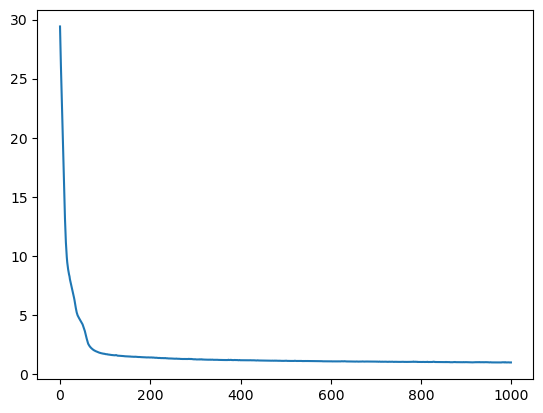

In [19]:
plt.plot(loss)

In [20]:
model.eval()
latent = model.encoder(torch.tensor(X)).detach().cpu().numpy()

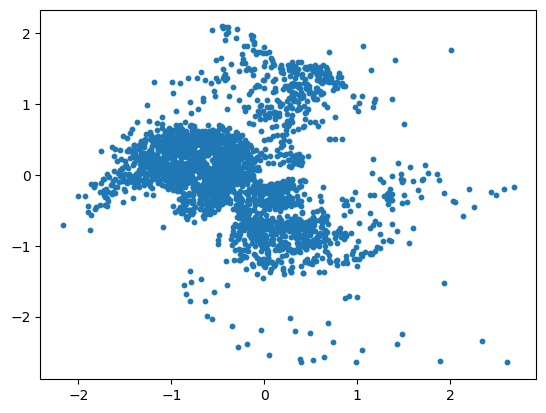

In [21]:
plt.scatter(latent[:, 0], latent[:, 1], s=10)

In [22]:
colormap = mpl.colormaps["Accent"]


In [23]:

X, order_of_flights = prepare_features(
    # t_f_20, list_features, scaler, points_per_flight=20
    t_f, list_features, scaler, points_per_flight=64
)

model.eval()
latent = model.encoder(torch.tensor(X)).detach().cpu().numpy()

In [33]:
x = model.encoder.encoder(torch.tensor(X))
mu = model.encoder.mu(x)
sigma = torch.exp(model.encoder.sigma(x))
latent = mu.detach().numpy()

In [25]:
latent.shape

(2617, 2)

In [25]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=5).fit(latent)
clusters = clustering.predict(latent)
np.unique(clusters, return_counts=True)

/opt/homebrew/Caskroom/miniforge/base/envs/artefact/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(array([0, 1, 2, 3, 4], dtype=int32), array([866, 599, 137, 693, 322]))

In [365]:
from sklearn.cluster import OPTICS

clustering = OPTICS(min_samples=30).fit(latent)
clusters = clustering.labels_
np.unique(clusters, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]),
 array([1492,   33,   68,   47,   36,   57,  100,   63,   35,   48,   52,
          36,   46,   92,  102,   36,   89,   47,   49,   59,   30]))

In [34]:
from sklearn.mixture import GaussianMixture

clustering = GaussianMixture(n_components=4).fit(latent)
clusters = clustering.predict(latent)
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3]), array([ 773, 1401,  311,  132]))

In [38]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.1, min_samples=20).fit(latent)
# clusters = clustering.predict(latent)
clusters = clustering.labels_
np.unique(clusters, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5]),
 array([ 616, 1703,  190,   55,   24,   20,    9]))

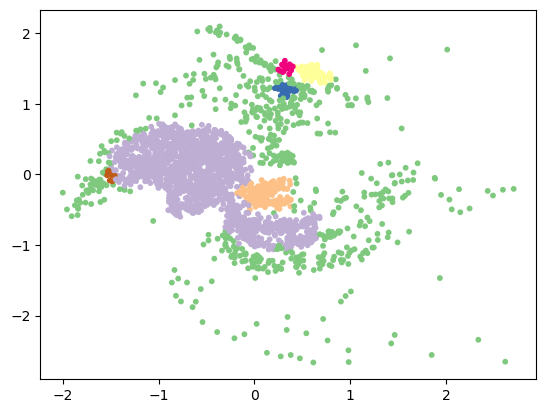

In [39]:
plt.scatter(latent[:, 0], latent[:, 1], c=[colormap(c+1) for c in clusters], s=10)

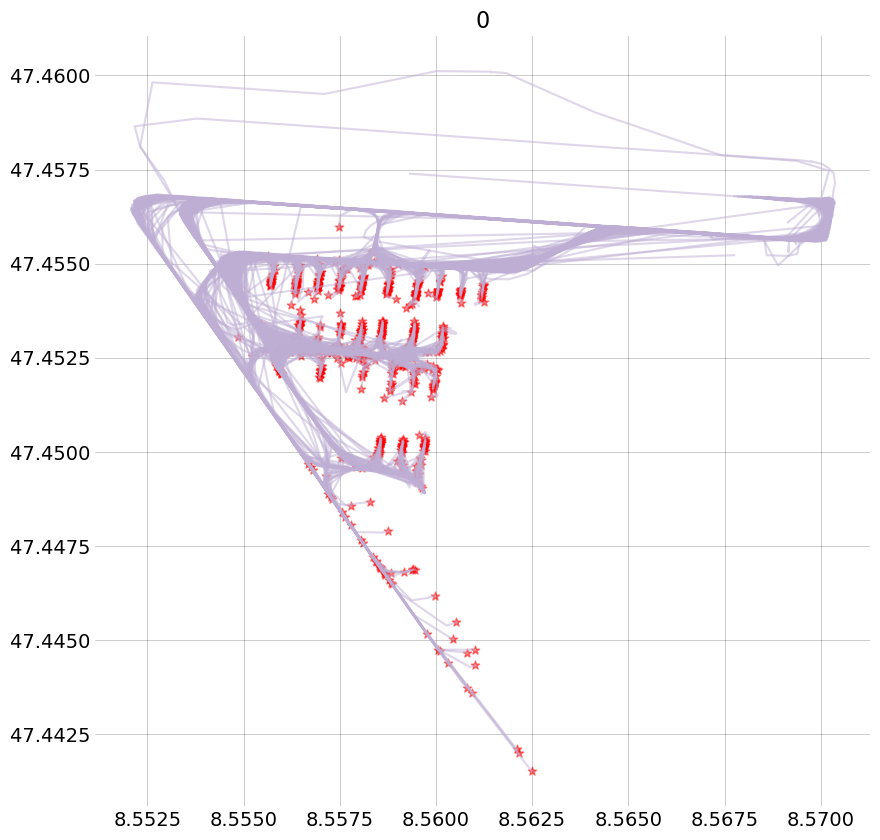

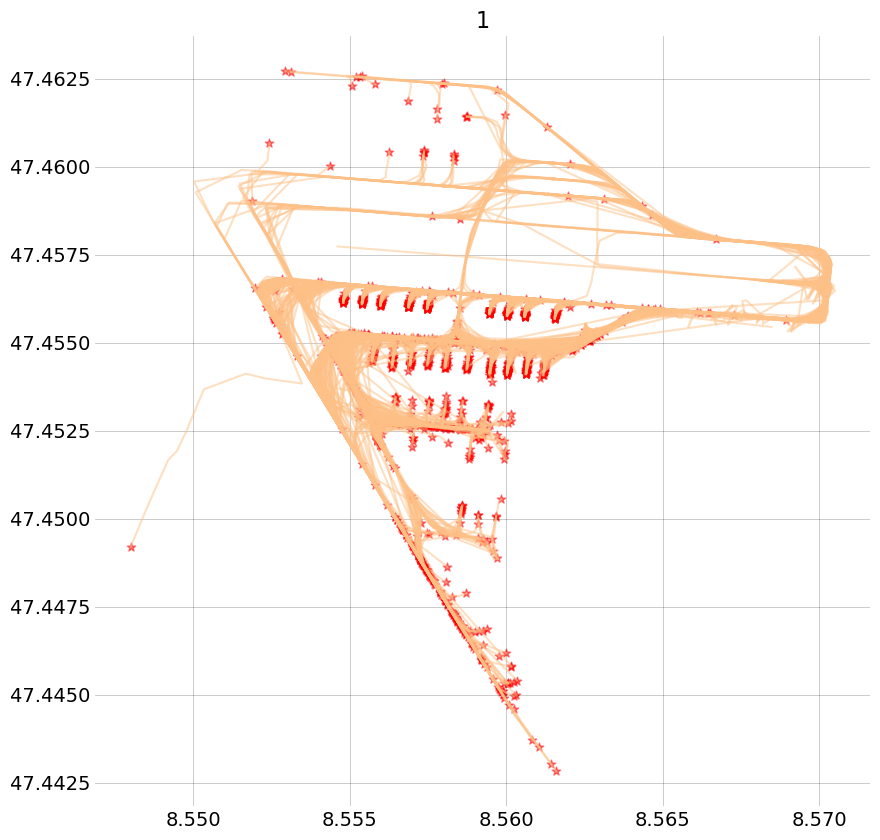

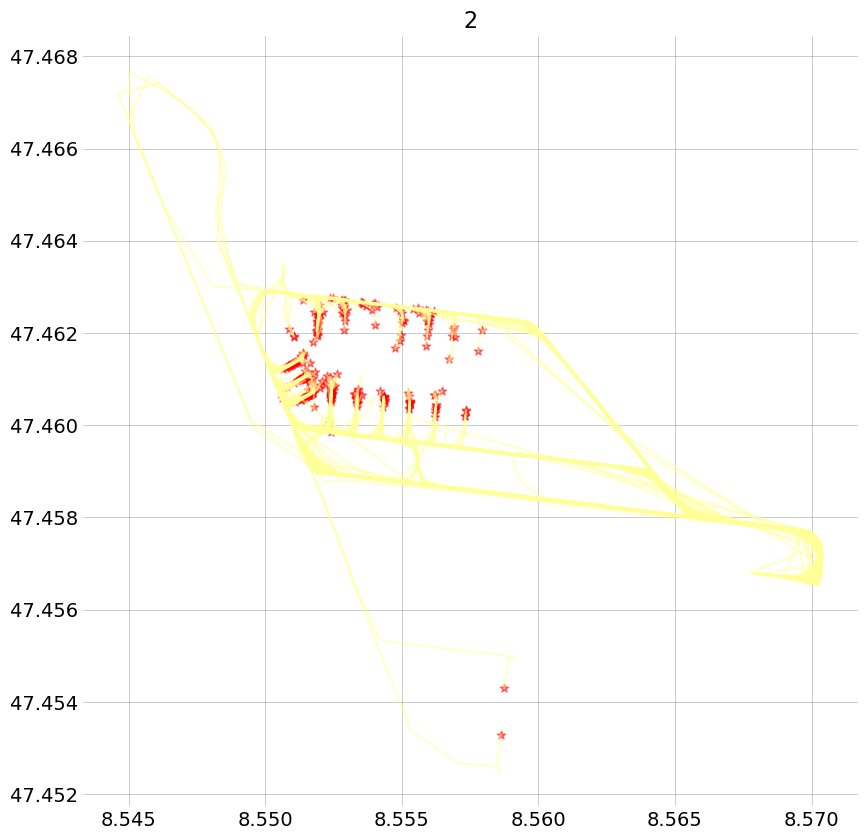

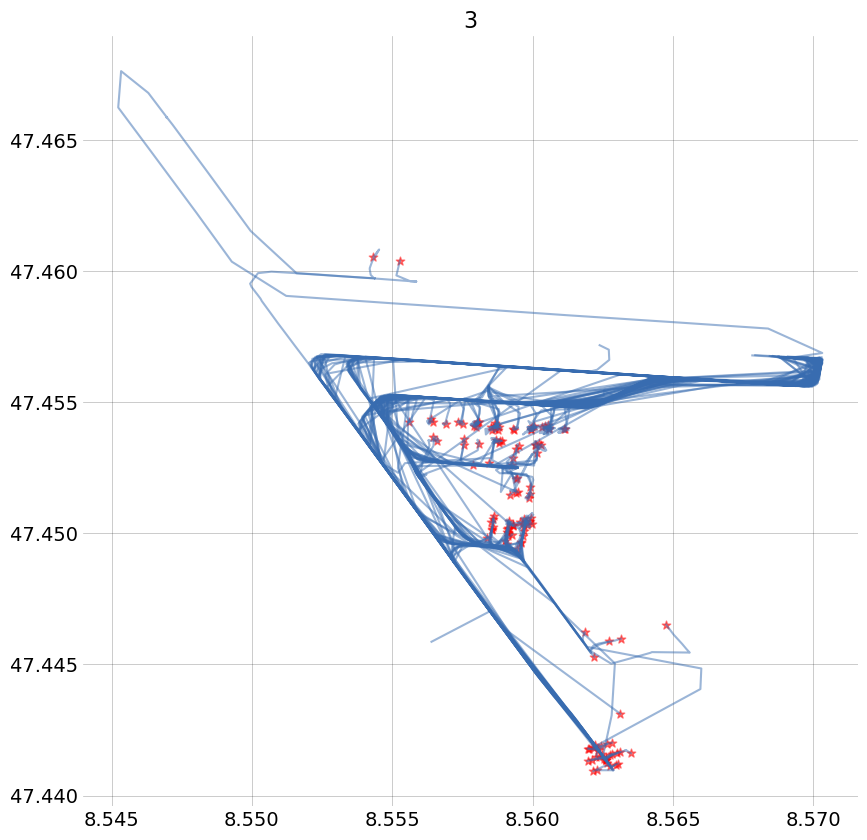

In [36]:
for cluster_ in np.unique(clusters):
    with plt.style.context("traffic"):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(cluster_)

        for cluster, flight_id in zip(clusters, order_of_flights):
            if cluster != cluster_:
                continue
            flight = t_f[flight_id]
            ax.scatter(
                flight.data.longitude.iloc[0],
                flight.data.latitude.iloc[0],
                s=40,
                color="red",
                marker="*",
                alpha=0.5,
            )
            flight.plot(ax=ax, alpha=0.5, color=colormap(cluster+1))
        
        plt.show()

In [310]:
flights = []
t_f_2 = Traffic(t_f.data.copy())
for flight in t_f_2:
    # print(flight.data.index)
    # flight = flight.reset_index(drop=True)
    # print(flight.data.index)
    # flights.append(flight.resample(20))

    df = flight.data.reindex(range(20), method="nearest")
    flights.append(Flight(df.copy()))

t_f_20 = Traffic.from_flights(flights)


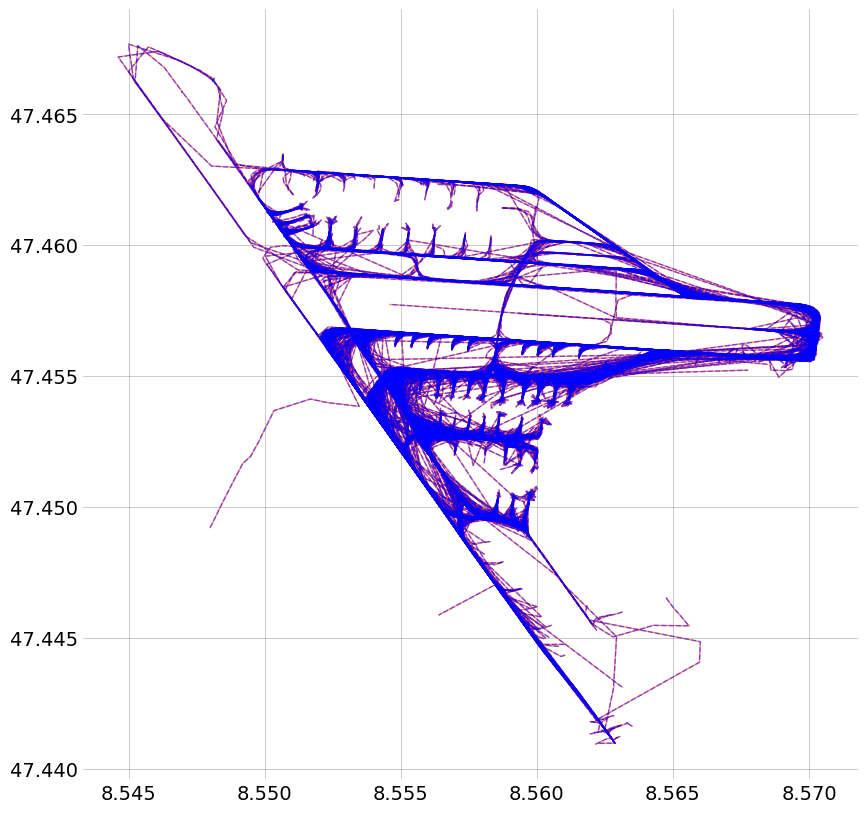

In [311]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(10, 10))

    t_f.plot(ax=ax, color="red", alpha=0.5)
    t_f_2.plot(ax=ax, color="blue", linestyle="--",alpha=0.5)

In [41]:
X_20, order_of_flights = prepare_features(
    t_f_20, list_features, scaler, points_per_flight=20
)


NameError: name 't_f_20' is not defined

In [320]:
from sklearn.manifold import TSNE

embedded = TSNE(n_components=2).fit_transform(X_20)

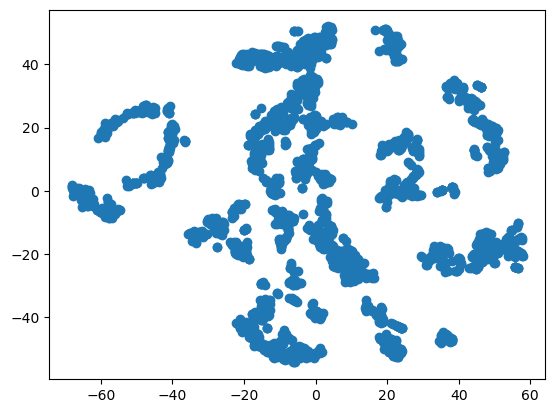

In [321]:
plt.scatter(embedded[:, 0], embedded[:, 1],)#) c=[colormap(cluster+1) for cluster in clusters], s=5)

In [259]:
clustering = KMeans(n_clusters=4).fit(embedded)
clusters = clustering.predict(embedded)
np.unique(clusters, return_counts=True)

/opt/homebrew/Caskroom/miniforge/base/envs/artefact/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(array([0, 1, 2, 3], dtype=int32), array([575, 877, 636, 529]))

In [40]:
clustering = GaussianMixture(n_components=20).fit(embedded)
clusters = clustering.predict(embedded)
np.unique(clusters, return_counts=True)

NameError: name 'embedded' is not defined

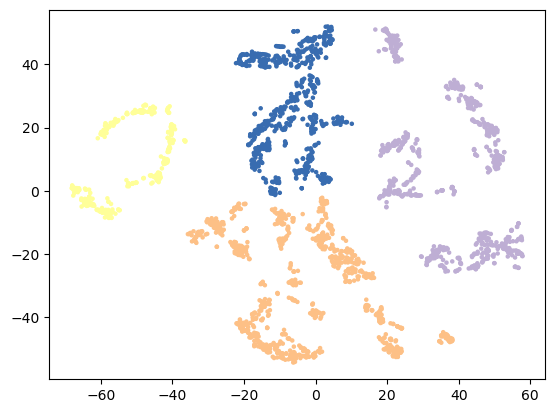

In [323]:
plt.scatter(embedded[:, 0], embedded[:, 1], c=[colormap(cluster+1) for cluster in clusters], s=5)

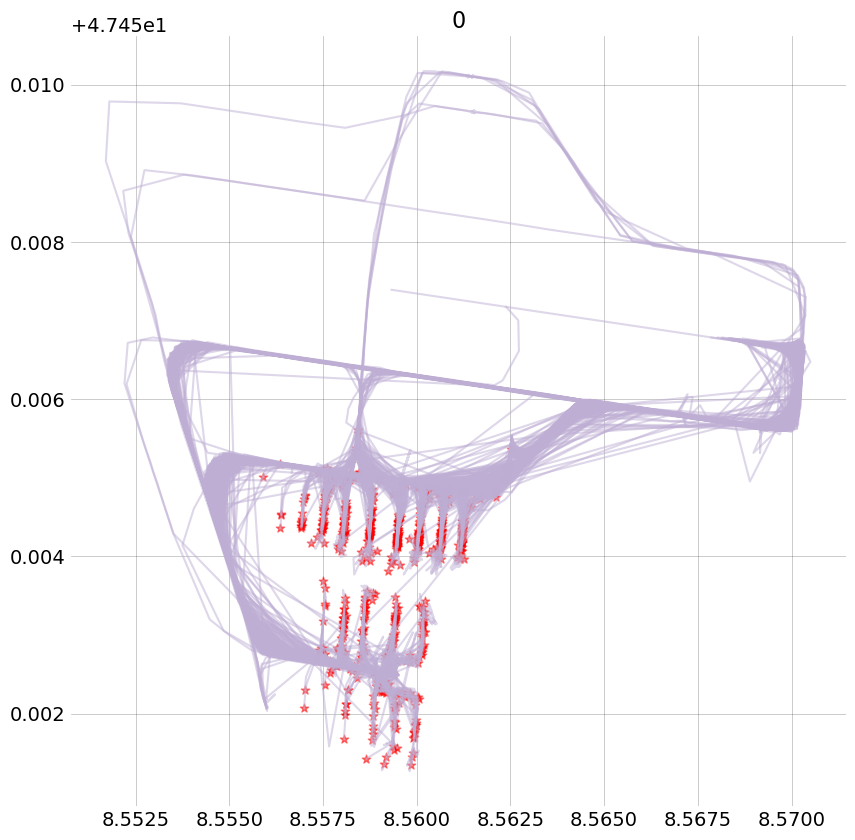

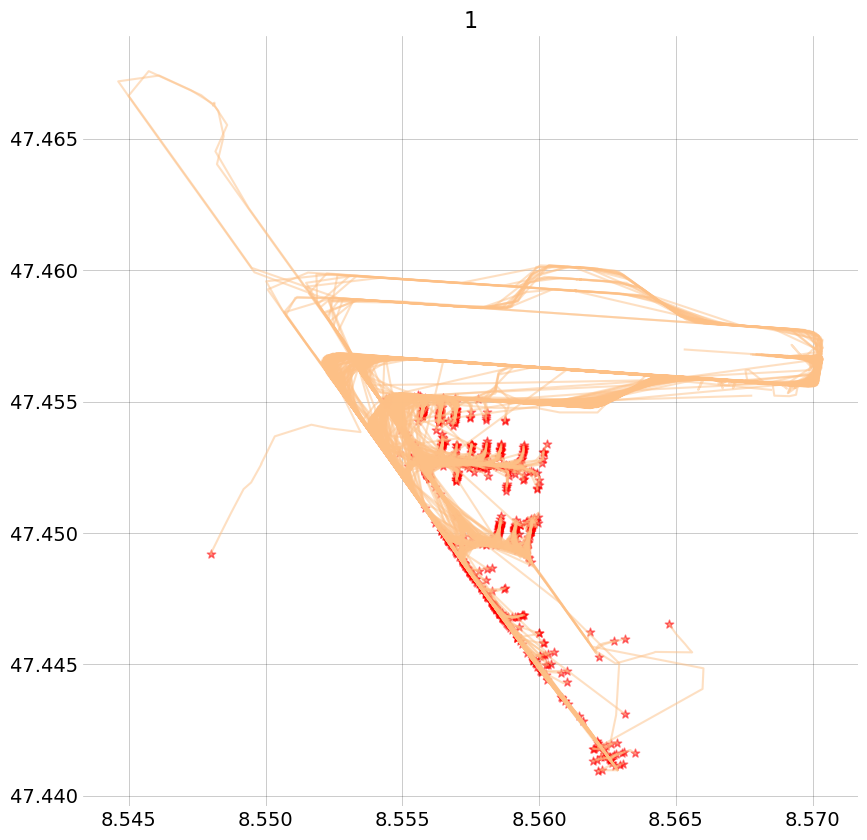

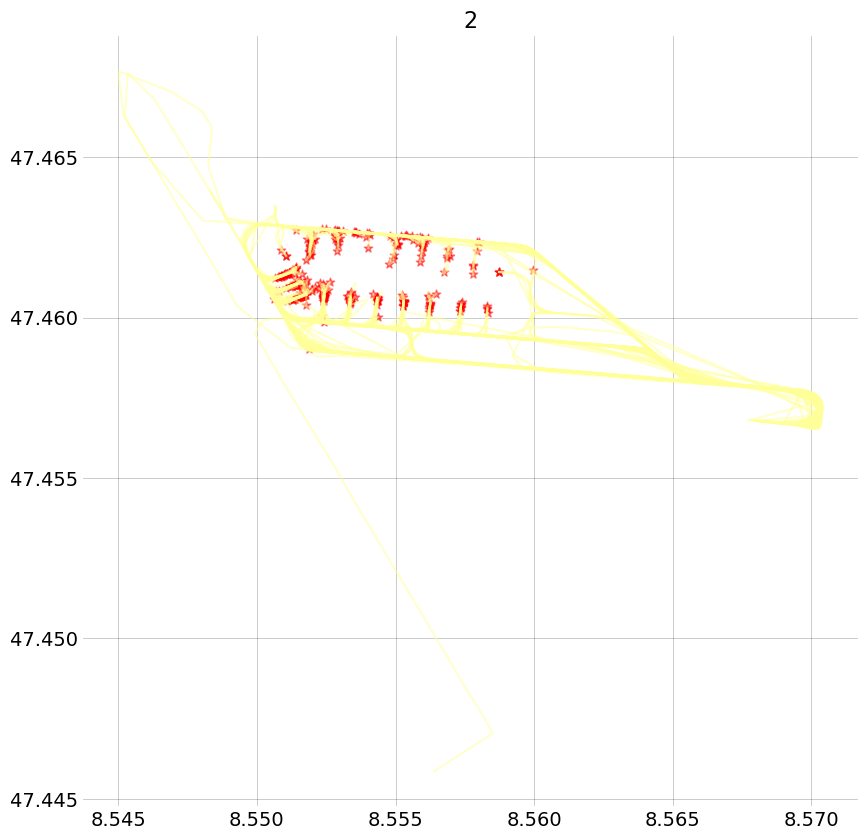

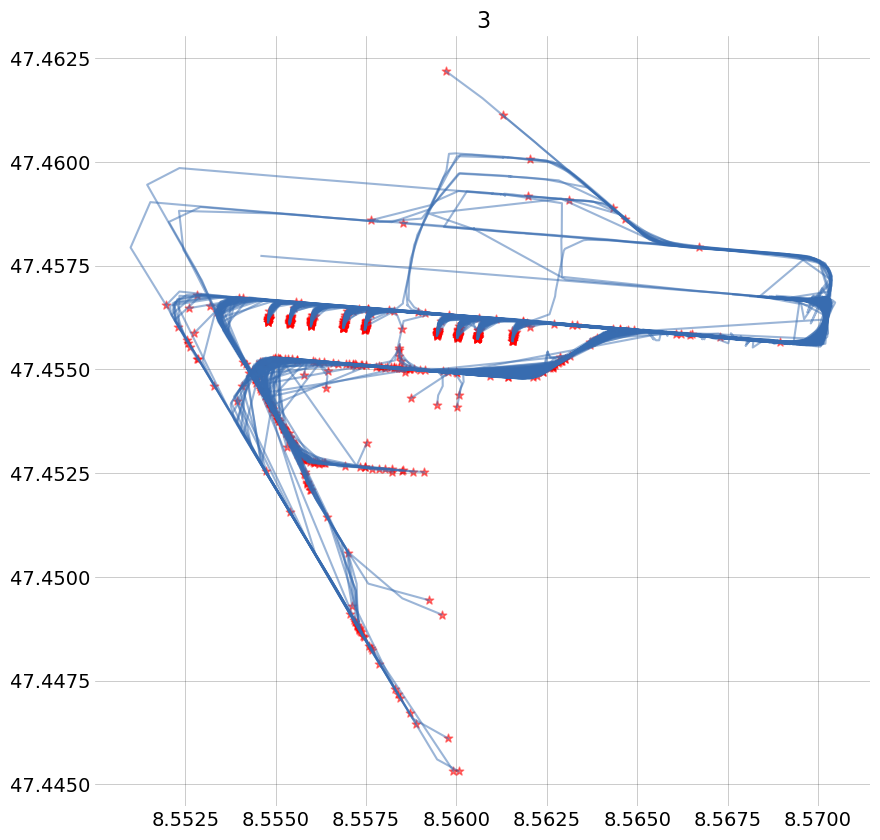

In [324]:
for cluster_ in np.unique(clusters):
    with plt.style.context("traffic"):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(cluster_)

        for cluster, flight_id in zip(clusters, order_of_flights):
            if cluster != cluster_:
                continue
            flight = t_f[flight_id]
            ax.scatter(
                flight.data.longitude.iloc[0],
                flight.data.latitude.iloc[0],
                s=40,
                color="red",
                marker="*",
                alpha=0.5,
            )
            flight.plot(ax=ax, alpha=0.5, color=colormap(cluster+1))
        
        plt.show()